In [ ]:
%pip install mabwiser

In [ ]:
from mabwiser.mab import MAB, LearningPolicy, NeighborhoodPolicy
import numpy as np
import pandas as pd
from itertools import permutations 
import matplotlib.pyplot as plt
import heapq
from scipy.stats import uniform
import random
from sklearn.preprocessing import StandardScaler

In [ ]:
# Utility functions

def permutation(possibilities, length):
    perm = permutations(possibilities, length) 
    return list(perm)

def truncate(value, min=0, max=1):
    if (value < min): value = min
    if (value > max): value = max
    return value

def sample_gaussian(loc=0.5, scale=0.5, size=1):
    result = np.random.normal(loc=loc, scale=scale, size=size)
    for i in range(len(result)):
        result[i] = truncate(result[i])
    return result

In [ ]:
sample_gaussian()

(array([174654.,  17865.,  18544.,  19953.,  20773.,  21735.,  22691.,
         23493.,  24334.,  24989.,  25381.,  25918.,  26267.,  26754.,
         26709.,  26592.,  26403.,  26289.,  26065.,  25193.,  24814.,
         24334.,  23513.,  22530.,  21789.,  20818.,  19901.,  18824.,
         17844., 175031.]),
 array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
        0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
        0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
        0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
        0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
        0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
        1.        ]),
 <BarContainer object of 30 artists>)

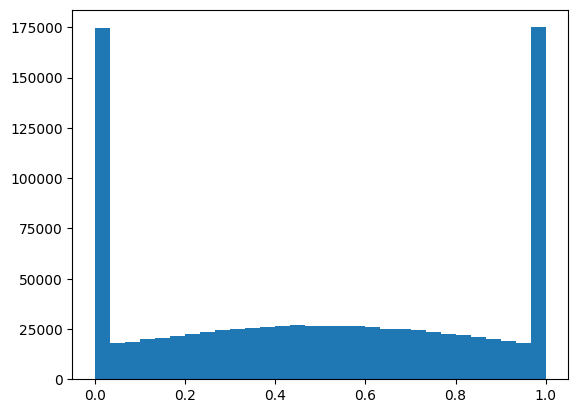

In [499]:
plt.hist(sample_gaussian(loc=0.5, scale=0.5, size=1000000), bins=30)

In [ ]:
# Iterated Boolean Game

class IteratedBooleanGame:
    # A constructor where initial boolean variable states are passed
    def __init__(self, vars):
        self.evolution = []
        self.evolution.append(vars)
        self.agents = []
        self.message_queue = []
        self.master_clk = 0
        self.phi_matched = 0
        self.psi_matched = 0
        self.cumu_phi_matched = [0]
        self.cumu_psi_matched = [0]
    
    # Check if a subset (from start to stop) satisfies phi LTL
    # Return the details of the first-matched message sequence
    def check_phi(self, start, stop):
        seq_start = -1
        initial_found = False # Found (F, F)
        for i in range(start, stop + 1):
            if self.evolution[i] == (False, False):
                initial_found = True
                seq_start = i
            if initial_found and self.evolution[i] == (True, False) and (i + 1) <= stop:
                if self.evolution[i + 1] == (True, True):
                    return {"result": True, "seq_start": seq_start, "seq_end": i + 1} # Phi matched
        return {"result": False, "seq_start": -1, "seq_end": -1} # Phi not matched
    
    # Similar to the check_phi one but for psi LTL
    def check_psi(self, start, stop):
        seq_start = -1
        initial_satisfied = False # Found (F, F) -> X(F, T)
        for i in range(start, stop + 1):
            if self.evolution[i] == (False, False) and (i + 1) <= stop:
                if self.evolution[i + 1] == (False, True):
                    initial_satisfied = True
                    seq_start = i
            if initial_satisfied and self.evolution[i] == (True, True):
                return {"result": True, "seq_start": seq_start, "seq_end": i} # Psi matched
        return {"result": False, "seq_start": -1, "seq_end": -1} # Psi not matched

    # Count the number of times phi LTL is satisfied in the evolution
    def phi_count(self):
        if (len(self.evolution) == 0):
            return 0
        result = 0
        r = self.check_phi(0, len(self.evolution) - 1)
        while r["result"]:
            result += 1
            next_start = r["seq_end"] + 1
            if (next_start >= len(self.evolution) or next_start == -1):
                break
            r = self.check_phi(next_start, len(self.evolution) - 1)
        return result
    
    # Count the number of times psi LTL is satisfied in the evolution
    def psi_count(self):
        if (len(self.evolution) == 0):
            return 0
        result = 0
        r = self.check_psi(0, len(self.evolution) - 1)
        while r["result"]:
            result += 1
            next_start = r["seq_end"] + 1
            if (next_start >= len(self.evolution) or next_start == -1):
                break
            r = self.check_psi(next_start, len(self.evolution) - 1)
        return result
    
    # A method to add agent to the game
    def add_agent(self, agent):
        self.agents.append(agent)
        
    # A method to start running simulation
    def simulate(self, max_time=10, timestep_log=False):

        # Clear previous result from the last simulation
        self.cumu_phi_matched = [0]
        self.cumu_psi_matched = [0]
        self.evolution = self.evolution[:1]
        self.message_queue = []
        self.master_clk = 0

        print("### Running Iterated Boolean Game Simulation ###")

        # At time step t = 0
        if timestep_log:
            print(f'> t = {self.master_clk:.2f} | {self.evolution[-1]} | Phi: {self.phi_matched} | Psi: {self.psi_matched}')

        # For every non-negative integer time step i.e., t = 0, 1, 2, 3, ...
        for t in range(max_time):
            # Update the game master clock
            self.master_clk = t

            # Receive message from each agent in the game
            for a in self.agents:
                m = a.get_message(self.phi_matched, self.psi_matched, self.evolution[-1])
                exe_time = self.master_clk + sample_gaussian()[0] # Add message latency ~ N(μ, σ)
                if m:
                    heapq.heappush(self.message_queue, (exe_time, m)) # If message exists, add it to the message queue
            
            # Process each message in the queue 
            while len(self.message_queue) > 0:
                if (self.message_queue[0][0] >= t and self.message_queue[0][0] < t + 1):
                    m = heapq.heappop(self.message_queue) # Message = (Time, (Var Idx, Val))
                    self.master_clk = m[0]
                    to_process = [m]
                    while len(self.message_queue) > 0 and self.message_queue[0][0] == m[0]:
                        m_matched = heapq.heappop(self.message_queue)
                        to_process.append(m_matched)
                    new_state = list(self.evolution[-1])
                    m_chosen = to_process[random.randint(0, len(to_process) - 1)]
                    new_state[m_chosen[1][0]] = m_chosen[1][1]
                    new_state = tuple(new_state)
                    self.evolution.append(new_state)

                    # Update phi_matched & psi_matched. However, this is not the most efficient way to do so, 
                    # will be improved in the next version
                    self.phi_matched = self.phi_count() 
                    self.psi_matched = self.psi_count()
                    if timestep_log:
                        print(f'> t = {self.master_clk:.2f} | {self.evolution[-1]} | Phi: {self.phi_matched} | Psi: {self.psi_matched}')
                else:
                    break

            # Each agent learns
            for a in self.agents:
                a.learn(self.phi_matched, self.psi_matched, self.evolution[-1])
            if (t % 1000 == 0):
                print("> " + str(int(t/max_time * 100)) + "% simulated")
            self.cumu_phi_matched.append(self.phi_matched)
            self.cumu_psi_matched.append(self.psi_matched)
        print("> Finished simulation")        
        print("#" * 30)    

    # A method to explain latest simulation
    def explain(self):
        print("### Explaining Latest Iterated Boolean Game Simulation ###")
        x = range(len(self.cumu_phi_matched))
        plt.plot(x, self.cumu_phi_matched, label='Phi', color='red')
        plt.plot(x, self.cumu_psi_matched, label='Psi', color='blue')
        plt.legend(loc='upper right')
        plt.xlabel("Time step")
        plt.ylabel("Total time(s) LTL satisfied")
        plt.show()
        print(f'Total Phi satisfaction: {self.phi_count()}')
        print(f'Total Psi satisfaction: {self.psi_count()}')
        for a in self.agents:
            a.explain()
        print("#" * 30)  


## Agent types to test gameplay performance

### Without MAB

#### 1. Choosing response message randomly

In [ ]:
class RandomResponseAgent:
    def __init__(self, internal_latency, objective):
        self.internal_latency = internal_latency
        self.objective = objective
        self.message_sent = []
        
    def get_message(self, phi_matched, psi_matched, current_state):
        s = [(0, False), (1, False), (0, True), (1, True)]
        m = s[random.randint(0, 3)]
        self.message_sent.append(m)
        return m

    def learn(self, phi_matched, psi_matched, current_state):
        return
    
    def explain(self):
        return

### Running Iterated Boolean Game Simulation ###
> 0% simulated
> 10% simulated
> 20% simulated
> 30% simulated
> 40% simulated
> 50% simulated
> 60% simulated
> 70% simulated
> 80% simulated
> 90% simulated
> Finished simulation
##############################
### Explaining Latest Iterated Boolean Game Simulation ###


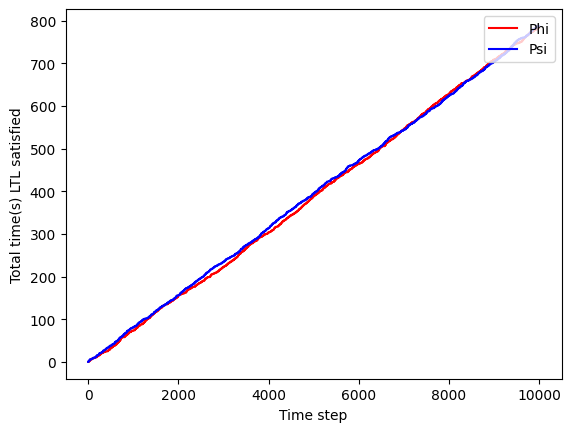

Total Phi satisfaction: 784
Total Psi satisfaction: 788
##############################


In [502]:
game1 = IteratedBooleanGame((False, False))
rand_agent1 = RandomResponseAgent(0, "phi")
rand_agent2 = RandomResponseAgent(0, "psi")
game1.add_agent(rand_agent1)
game1.add_agent(rand_agent2)
game1.simulate(max_time=10000)
game1.explain()

#### 2. Same response pattern without probing

In [ ]:
class PatternedResponseAgent:
    def __init__(self, internal_latency, objective):
        self.internal_latency = internal_latency
        self.objective = objective
        self.message_sent = []
        self.i = -1

    def get_message(self, phi_matched, psi_matched, current_state):
        self.i += 1
        s = []
        if self.objective == "phi":
            s = [(0, False), (1, False), (0, True), (1, True), (0, False), (1, False)]
        elif self.objective == "psi":
            s = [(0, False), (1, False), (1, True), (0, True), (0, False), (1, False)]
        m = s[self.i % 6]
        self.message_sent.append(m)
        return m

    def learn(self, phi_matched, psi_matched, current_state):
        return
    
    def explain(self):
        return


### Running Iterated Boolean Game Simulation ###
> 0% simulated
> 10% simulated
> 20% simulated
> 30% simulated
> 40% simulated
> 50% simulated
> 60% simulated
> 70% simulated
> 80% simulated
> 90% simulated
> Finished simulation
##############################
### Explaining Latest Iterated Boolean Game Simulation ###


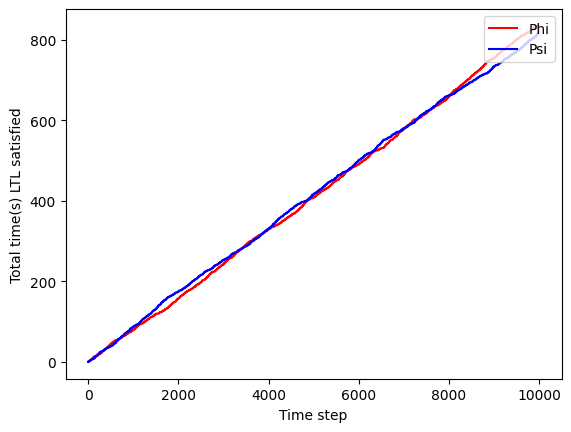

Total Phi satisfaction: 834
Total Psi satisfaction: 820
##############################


In [503]:
game2 = IteratedBooleanGame((False, False))
patterned_agent1 = PatternedResponseAgent(0, "phi")
patterned_agent2 = PatternedResponseAgent(0, "psi")
game2.add_agent(patterned_agent1)
game2.add_agent(patterned_agent2)
game2.simulate(max_time=10000)
game2.explain()

#### 3. Probe variables states & Response accordingly

In [ ]:
class ProbingAgent:
    def __init__(self, internal_latency, objective):
        self.internal_latency = internal_latency
        self.objective = objective
        self.message_sent = []
        self.i = -1

    def get_message(self, phi_matched, psi_matched, current_state):
        if self.objective == "phi":
            if current_state == (True, True):
                return (0, False)
            if current_state == (True, False):
                return (1, True)
            if current_state == (False, True):
                return (1, False)
            if current_state == (False, False):
                return (0, True)
        if self.objective == "psi":
            if current_state == (True, True):
                return (0, False)
            if current_state == (True, False):
                return (0, False)
            if current_state == (False, True):
                return (0, True)
            if current_state == (False, False):
                return (1, True)

    def learn(self, phi_matched, psi_matched, current_state):
        return
    
    def explain(self):
        return

### Running Iterated Boolean Game Simulation ###
> 0% simulated
> 10% simulated
> 20% simulated
> 30% simulated
> 40% simulated
> 50% simulated
> 60% simulated
> 70% simulated
> 80% simulated
> 90% simulated
> Finished simulation
##############################
### Explaining Latest Iterated Boolean Game Simulation ###


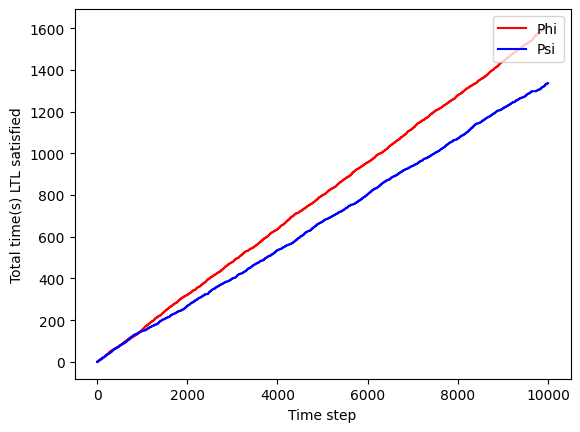

Total Phi satisfaction: 1611
Total Psi satisfaction: 1337
##############################


In [504]:
game3 = IteratedBooleanGame((False, False))
probing_agent1 = ProbingAgent(0, "phi")
probing_agent2 = ProbingAgent(0, "psi")
game3.add_agent(probing_agent1)
game3.add_agent(probing_agent2)
game3.simulate(max_time=10000)
game3.explain()

### With Multi-Armed Bandit

In [ ]:
arms_to_message = {'A->T': (0, True), 'A->F': (0, False), 'B->T': (1, True), 'B->F': (1, False), "Idle": None}
message_to_arms = {(0, True): 'A->T', (0, False): 'A->F' , (1, True): 'B->T', (1, False): 'B->F' ,  None: "Idle"}
stringify_state = {(True, True): '(T, T)', (True, False): '(T, F)' , (False, True): '(F, T)', (False, False): '(F, F)'}

#### 4. Naive arm choice (One arm for each possible response)

In [ ]:
class NaiveMABAgent:
    def __init__(self, internal_latency, objective, mab):
        self.internal_latency = internal_latency
        self.objective = objective
        self.mab = mab
        self.message_sent = []
        self.times_matched = 0

    def get_message(self, phi_matched, psi_matched, current_state):
        if (self.objective == "phi"):
            self.times_matched = phi_matched
        elif (self.objective == "psi"):
            self.times_matched = psi_matched
        arm_picked = self.mab.predict()
        self.message_sent.append(arm_picked)
        return arms_to_message[arm_picked]

    def learn(self, phi_matched, psi_matched, current_state):
        if (self.objective == "phi"):
            self.mab.partial_fit([self.message_sent[-1]], [phi_matched - self.times_matched])
        elif (self.objective == "psi"):
            self.mab.partial_fit([self.message_sent[-1]], [psi_matched - self.times_matched])
    
    def explain(self):
        print(" - " + self.objective + " agent expectation for each arm")
        print(self.mab._imp.arm_to_expectation)

In [421]:
def sim_mab1(max_time, learn_policy=LearningPolicy.Softmax(tau=0.3)):

    # MAB Setup
    arms = ['A->T', 'A->F', 'B->T', 'B->F'] # Each arm represents one possible response
    mab1 = MAB(arms, learn_policy)
    mab1.fit([], [])
    mab2 = MAB(arms, learn_policy)
    mab2.fit([], [])

    game = IteratedBooleanGame((False, False))
    naivemab_agent1 = NaiveMABAgent(0, "phi", mab1)
    naivemab_agent2 = NaiveMABAgent(0, "psi", mab2)
    game.add_agent(naivemab_agent1)
    game.add_agent(naivemab_agent2)

    game.simulate(max_time=max_time)
    # game.explain()

    return game

* Learning policy comparison

### Running Iterated Boolean Game Simulation ###
> 0% simulated
> 10% simulated
> 20% simulated
> 30% simulated
> 40% simulated
> 50% simulated
> 60% simulated
> 70% simulated
> 80% simulated
> 90% simulated
> Finished simulation
##############################
### Running Iterated Boolean Game Simulation ###
> 0% simulated
> 10% simulated
> 20% simulated
> 30% simulated
> 40% simulated
> 50% simulated
> 60% simulated
> 70% simulated
> 80% simulated
> 90% simulated
> Finished simulation
##############################
### Running Iterated Boolean Game Simulation ###
> 0% simulated
> 10% simulated
> 20% simulated
> 30% simulated
> 40% simulated
> 50% simulated
> 60% simulated
> 70% simulated
> 80% simulated
> 90% simulated
> Finished simulation
##############################
### Running Iterated Boolean Game Simulation ###
> 0% simulated
> 10% simulated
> 20% simulated
> 30% simulated
> 40% simulated
> 50% simulated
> 60% simulated
> 70% simulated
> 80% simulated
> 90% simulated
> Finishe

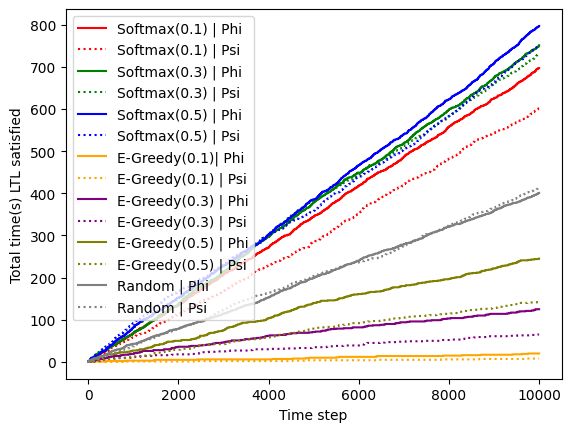

In [434]:
max_time = 10000

test1 = sim_mab1(max_time=max_time, learn_policy=LearningPolicy.Softmax(tau=0.1))
test2 = sim_mab1(max_time=max_time, learn_policy=LearningPolicy.Softmax(tau=0.3))
test3 = sim_mab1(max_time=max_time, learn_policy=LearningPolicy.Softmax(tau=0.5))
test4 = sim_mab1(max_time=max_time, learn_policy=LearningPolicy.EpsilonGreedy(epsilon=0.1))
test5 = sim_mab1(max_time=max_time, learn_policy=LearningPolicy.EpsilonGreedy(epsilon=0.3))
test6 = sim_mab1(max_time=max_time, learn_policy=LearningPolicy.EpsilonGreedy(epsilon=0.5))
test_base = sim_mab1(max_time=max_time, learn_policy=LearningPolicy.Random())


x = range(max_time + 1)
plt.plot(x, test1.cumu_phi_matched, label='Softmax(0.1) | Phi', color='red',)
plt.plot(x, test1.cumu_psi_matched, label='Softmax(0.1) | Psi', color='red', linestyle = 'dotted')
plt.plot(x, test2.cumu_phi_matched, label='Softmax(0.3) | Phi', color='green',)
plt.plot(x, test2.cumu_psi_matched, label='Softmax(0.3) | Psi', color='green', linestyle = 'dotted')
plt.plot(x, test3.cumu_phi_matched, label='Softmax(0.5) | Phi', color='blue',)
plt.plot(x, test3.cumu_psi_matched, label='Softmax(0.5) | Psi', color='blue', linestyle = 'dotted')
plt.plot(x, test4.cumu_phi_matched, label='E-Greedy(0.1)| Phi', color='orange',)
plt.plot(x, test4.cumu_psi_matched, label='E-Greedy(0.1) | Psi', color='orange', linestyle = 'dotted')
plt.plot(x, test5.cumu_phi_matched, label='E-Greedy(0.3) | Phi', color='purple',)
plt.plot(x, test5.cumu_psi_matched, label='E-Greedy(0.3) | Psi', color='purple', linestyle = 'dotted')
plt.plot(x, test6.cumu_phi_matched, label='E-Greedy(0.5) | Phi', color='olive',)
plt.plot(x, test6.cumu_psi_matched, label='E-Greedy(0.5) | Psi', color='olive', linestyle = 'dotted')
plt.plot(x, test_base.cumu_phi_matched, label='Random | Phi', color='gray',)
plt.plot(x, test_base.cumu_psi_matched, label='Random | Psi', color='gray', linestyle = 'dotted')

plt.xlabel("Time step")
plt.ylabel("Total time(s) LTL satisfied")
plt.legend(loc='upper left')
plt.show()

* Simulation

### Running Iterated Boolean Game Simulation ###
> 0% simulated
> 2% simulated
> 4% simulated
> 6% simulated
> 8% simulated
> 10% simulated
> 12% simulated
> 14% simulated
> 16% simulated
> 18% simulated
> 20% simulated
> 22% simulated
> 24% simulated
> 26% simulated
> 28% simulated
> 30% simulated
> 32% simulated
> 34% simulated
> 36% simulated
> 38% simulated
> 40% simulated
> 42% simulated
> 44% simulated
> 46% simulated
> 48% simulated
> 50% simulated
> 52% simulated
> 54% simulated
> 56% simulated
> 57% simulated
> 60% simulated
> 62% simulated
> 64% simulated
> 66% simulated
> 68% simulated
> 70% simulated
> 72% simulated
> 74% simulated
> 76% simulated
> 78% simulated
> 80% simulated
> 82% simulated
> 84% simulated
> 86% simulated
> 88% simulated
> 90% simulated
> 92% simulated
> 94% simulated
> 96% simulated
> 98% simulated
> Finished simulation
##############################
### Explaining Latest Iterated Boolean Game Simulation ###


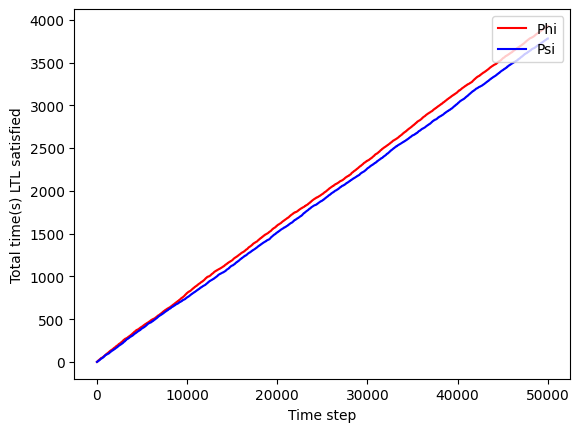

Total Phi satisfaction: 3928
Total Psi satisfaction: 3781
 - phi agent expectation for each arm
{'A->T': 0.23989728556385945, 'A->F': 0.2280575887459375, 'B->T': 0.29529454014839773, 'B->F': 0.23675058554180525}
 - psi agent expectation for each arm
{'A->T': 0.28455464747855286, 'A->F': 0.2334078712524337, 'B->T': 0.2523254481449952, 'B->F': 0.22971203312401817}
##############################


In [454]:
max_time = 50000
naivemab_sim = sim_mab1(max_time=max_time, learn_policy=LearningPolicy.Softmax(tau=0.5))
naivemab_sim.explain()

#### 5. Four bandits each with four arm
- Agent check current state of variables, pick the bandit, then call its predicted response
- Each possible state of variables {(T, T), (T, F), (F, T) and (F, F)} is represented by distinct bandit
  - In this case, there are 4 bandits in total shown by the map {(T, T): mab1, ..., (F, F): mab4}
- In each bandit, its arms represents all possible message responses.
  - Namely, A->T, A->F, B->T and B->F.
- For bandit reward learning, take φ as an example. In case of φ: (FF) -> F(TF) -> X(TT), satisfying φ has variables evolving to be (T, T) as a necessary condition.
  - Whenever (TT) is reached, all of the previous message attempts are learned with the reward of 1
  - On the other hand to learn the reward of 0, if probed current state is (F, F) all of the previous message attempts are learned with the reward of 0
- Since agents are aware of their LTLs, arm reward hints for MAB are given on start. (See MAB Dictionary Setup)

In [412]:
class MultipleBanditAgent:

    def __init__(self, internal_latency, objective, mab_dict):
        self.internal_latency = internal_latency
        self.objective = objective
        self.mab_dict = mab_dict
        self.attempt = []
        self.success_length = []
        self.failed_length = []
        self.mean_success_length = []
        self.mean_failed_length = []
        self.times_matched = 0

    def get_message(self, phi_matched, psi_matched, current_state):
        if (self.objective == "phi"):
            self.times_matched = phi_matched
        elif (self.objective == "psi"):
            self.times_matched = psi_matched

        # Choose which MAB to predict based on the current state
        arm_picked = self.mab_dict[current_state].predict()
        self.attempt.append((current_state, arm_picked))

        return arms_to_message[arm_picked]
    
    def learn(self, phi_matched, psi_matched, current_state):
        change = 0
        if (self.objective == "phi"):
            change = phi_matched - self.times_matched
        if (self.objective == "psi"):
            change = psi_matched - self.times_matched
            
        if (change == 1):
            # Success attempt
            for state_msg in self.attempt:
                self.mab_dict[state_msg[0]].partial_fit([state_msg[1]], [1])
            self.success_length.append(len(self.attempt))
            self.mean_success_length.append(np.mean(self.success_length))
            self.attempt.clear()
        elif (current_state == (False, False)):
            # Failed attempt
            for state_msg in self.attempt:
                self.mab_dict[state_msg[0]].partial_fit([state_msg[1]], [0])
            self.failed_length.append(len(self.attempt))
            self.mean_failed_length.append(np.mean(self.failed_length))
            self.attempt.clear()

    def explain(self):
        print(" - " + self.objective + " agent bandits expectation")
        for states in self.mab_dict:
            print("  - Bandit for current state = " + stringify_state[states])
            print(self.mab_dict[states]._imp.arm_to_expectation)

In [437]:
def sim_mab2(max_time, learn_policy=LearningPolicy.Softmax(tau=0.3)):

    # Arms setup
    arms = ['A->T', 'A->F', 'B->T', 'B->F']

    # φ: (FF) -> F(TF) -> X(TT)
    # s = [(0, False), (1, False), (0, True), (1, True), (0, False), (1, False)]
    # F? -> FF -> TF -> TT -> FT -> FF
    mab1 = MAB(arms, learn_policy)
    mab1.fit(arms, [0, 10, 0, 0]) # (True, True)
    mab2 = MAB(arms, learn_policy)
    mab2.fit(arms, [0, 0, 10, 0]) # (True, False)
    mab3 = MAB(arms, learn_policy)
    mab3.fit(arms, [0, 0, 0, 10]) # (False, True)
    mab4 = MAB(arms, learn_policy)
    mab4.fit(arms, [10, 0, 0, 0]) # (False, False)

    # ψ: (FF) -> X(FT) -> F(TT)
    # s = [(0, False), (1, False), (1, True), (0, True), (0, False), (1, False)]
    # ?? -> F? -> FF -> FT -> TT -> FT -> FF
    mab5 = MAB(arms, learn_policy)
    mab5.fit(arms, [0, 10, 0, 0]) # (True, True)
    mab6 = MAB(arms, learn_policy)
    mab6.fit(arms, [0, 10, 0, 0]) # (True, False)
    mab7 = MAB(arms, learn_policy)
    mab7.fit(arms, [10, 0, 0, 0]) # (False, True)
    mab8 = MAB(arms, learn_policy)
    mab8.fit(arms, [0, 0, 10, 0]) # (False, False)

    mab_dict_1 = {(True, True): mab1, (True, False): mab2, (False, True): mab3, (False, False): mab4}
    mab_dict_2 = {(True, True): mab5, (True, False): mab6, (False, True): mab7, (False, False): mab8}

    multibandit_agent1 = MultipleBanditAgent(0, "phi", mab_dict_1)
    multibandit_agent2 = MultipleBanditAgent(0, "psi", mab_dict_2)

    game = IteratedBooleanGame((False, False))
    game.add_agent(multibandit_agent1)
    game.add_agent(multibandit_agent2)
    game.simulate(max_time=max_time)
    
    return game

* Learning policy comparison

### Running Iterated Boolean Game Simulation ###
> 0% simulated
> 10% simulated
> 20% simulated
> 30% simulated
> 40% simulated
> 50% simulated
> 60% simulated
> 70% simulated
> 80% simulated
> 90% simulated
> Finished simulation
##############################
### Running Iterated Boolean Game Simulation ###
> 0% simulated
> 10% simulated
> 20% simulated
> 30% simulated
> 40% simulated
> 50% simulated
> 60% simulated
> 70% simulated
> 80% simulated
> 90% simulated
> Finished simulation
##############################
### Running Iterated Boolean Game Simulation ###
> 0% simulated
> 10% simulated
> 20% simulated
> 30% simulated
> 40% simulated
> 50% simulated
> 60% simulated
> 70% simulated
> 80% simulated
> 90% simulated
> Finished simulation
##############################
### Running Iterated Boolean Game Simulation ###
> 0% simulated
> 10% simulated
> 20% simulated
> 30% simulated
> 40% simulated
> 50% simulated
> 60% simulated
> 70% simulated
> 80% simulated
> 90% simulated
> Finishe

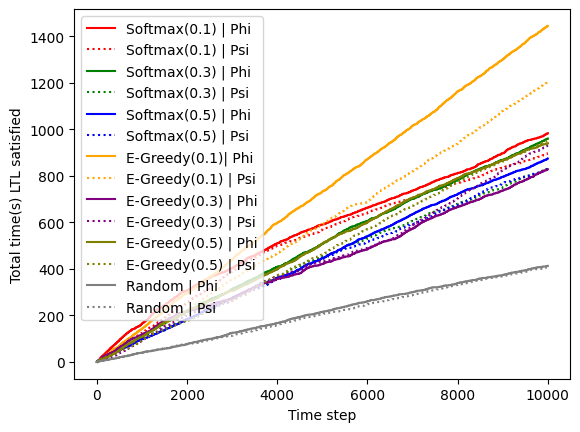

In [496]:
max_time = 10000

test1 = sim_mab2(max_time=max_time, learn_policy=LearningPolicy.Softmax(tau=0.1))
test2 = sim_mab2(max_time=max_time, learn_policy=LearningPolicy.Softmax(tau=0.3))
test3 = sim_mab2(max_time=max_time, learn_policy=LearningPolicy.Softmax(tau=0.5))
test4 = sim_mab2(max_time=max_time, learn_policy=LearningPolicy.EpsilonGreedy(epsilon=0.1))
test5 = sim_mab2(max_time=max_time, learn_policy=LearningPolicy.EpsilonGreedy(epsilon=0.3))
test6 = sim_mab2(max_time=max_time, learn_policy=LearningPolicy.EpsilonGreedy(epsilon=0.5))
test_base = sim_mab2(max_time=max_time, learn_policy=LearningPolicy.Random())


x = range(max_time + 1)
plt.plot(x, test1.cumu_phi_matched, label='Softmax(0.1) | Phi', color='red',)
plt.plot(x, test1.cumu_psi_matched, label='Softmax(0.1) | Psi', color='red', linestyle = 'dotted')
plt.plot(x, test2.cumu_phi_matched, label='Softmax(0.3) | Phi', color='green',)
plt.plot(x, test2.cumu_psi_matched, label='Softmax(0.3) | Psi', color='green', linestyle = 'dotted')
plt.plot(x, test3.cumu_phi_matched, label='Softmax(0.5) | Phi', color='blue',)
plt.plot(x, test3.cumu_psi_matched, label='Softmax(0.5) | Psi', color='blue', linestyle = 'dotted')
plt.plot(x, test4.cumu_phi_matched, label='E-Greedy(0.1)| Phi', color='orange',)
plt.plot(x, test4.cumu_psi_matched, label='E-Greedy(0.1) | Psi', color='orange', linestyle = 'dotted')
plt.plot(x, test5.cumu_phi_matched, label='E-Greedy(0.3) | Phi', color='purple',)
plt.plot(x, test5.cumu_psi_matched, label='E-Greedy(0.3) | Psi', color='purple', linestyle = 'dotted')
plt.plot(x, test6.cumu_phi_matched, label='E-Greedy(0.5) | Phi', color='olive',)
plt.plot(x, test6.cumu_psi_matched, label='E-Greedy(0.5) | Psi', color='olive', linestyle = 'dotted')
plt.plot(x, test_base.cumu_phi_matched, label='Random | Phi', color='gray',)
plt.plot(x, test_base.cumu_psi_matched, label='Random | Psi', color='gray', linestyle = 'dotted')

plt.xlabel("Time step")
plt.ylabel("Total time(s) LTL satisfied")
plt.legend(loc='upper left')
plt.show()

*  Simulation

### Running Iterated Boolean Game Simulation ###
> 0% simulated
> 2% simulated
> 4% simulated
> 6% simulated
> 8% simulated
> 10% simulated
> 12% simulated
> 14% simulated
> 16% simulated
> 18% simulated
> 20% simulated
> 22% simulated
> 24% simulated
> 26% simulated
> 28% simulated
> 30% simulated
> 32% simulated
> 34% simulated
> 36% simulated
> 38% simulated
> 40% simulated
> 42% simulated
> 44% simulated
> 46% simulated
> 48% simulated
> 50% simulated
> 52% simulated
> 54% simulated
> 56% simulated
> 57% simulated
> 60% simulated
> 62% simulated
> 64% simulated
> 66% simulated
> 68% simulated
> 70% simulated
> 72% simulated
> 74% simulated
> 76% simulated
> 78% simulated
> 80% simulated
> 82% simulated
> 84% simulated
> 86% simulated
> 88% simulated
> 90% simulated
> 92% simulated
> 94% simulated
> 96% simulated
> 98% simulated
> Finished simulation
##############################
### Explaining Latest Iterated Boolean Game Simulation ###


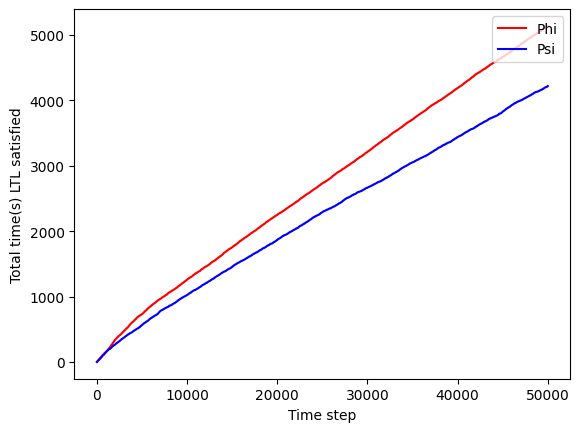

Total Phi satisfaction: 5138
Total Psi satisfaction: 4218
 - phi agent bandits expectation
  - Bandit for current state = (T, T)
{'A->T': 0.2809511987586106, 'A->F': 0.16801366035520146, 'B->T': 0.27223213318419354, 'B->F': 0.2788030077019944}
  - Bandit for current state = (T, F)
{'A->T': 0.2681481297950322, 'A->F': 0.020540474704917745, 'B->T': 0.6629642458722732, 'B->F': 0.048347149627776725}
  - Bandit for current state = (F, T)
{'A->T': 0.30486510671351486, 'A->F': 0.16660141263140552, 'B->T': 0.2648053043009373, 'B->F': 0.2637281763541424}
  - Bandit for current state = (F, F)
{'A->T': 0.9988397035320692, 'A->F': 0.00038676548931023845, 'B->T': 0.00038676548931023845, 'B->F': 0.00038676548931023845}
 - psi agent bandits expectation
  - Bandit for current state = (T, T)
{'A->T': 0.27825118603573923, 'A->F': 0.1714782491991411, 'B->T': 0.3098310079626861, 'B->F': 0.24043955680243354}
  - Bandit for current state = (T, F)
{'A->T': 0.15103830671087387, 'A->F': 0.4554918653441835, 'B-

In [497]:
max_time = 50000
multiplemab1_sim = sim_mab2(max_time=max_time, learn_policy=LearningPolicy.Softmax(tau=0.1))
multiplemab1_sim.explain()

* Analysis of message length on success attempts

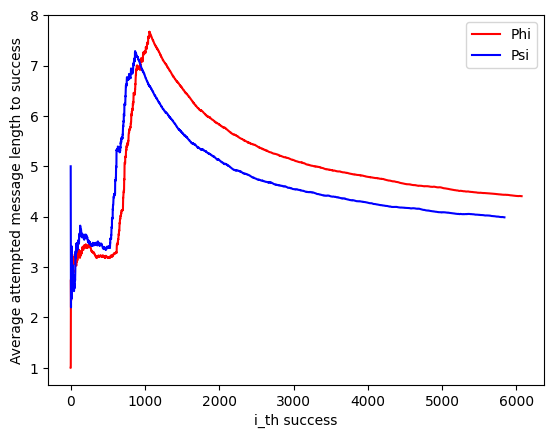

Phi: Average attempted message length to success  4.407084019769358
Psi: Average attempted message length to success 3.986984072615174


In [484]:
agents = multiplemab1_sim.agents
mean_slength_phi = agents[0].mean_success_length
mean_slength_psi = agents[1].mean_success_length
plt.plot(range(len(mean_slength_phi)), mean_slength_phi, label='Phi', color='red')
plt.plot(range(len(mean_slength_psi)), mean_slength_psi, label='Psi', color='blue')
plt.xlabel("i_th success")
plt.ylabel("Average attempted message length to success")
plt.legend(loc='upper right')
plt.show()
print("Phi: Average attempted message length to success ", np.average(agents[0].success_length))
print("Psi: Average attempted message length to success",np.average(agents[1].success_length))

* Analysis of message length on failed attempts

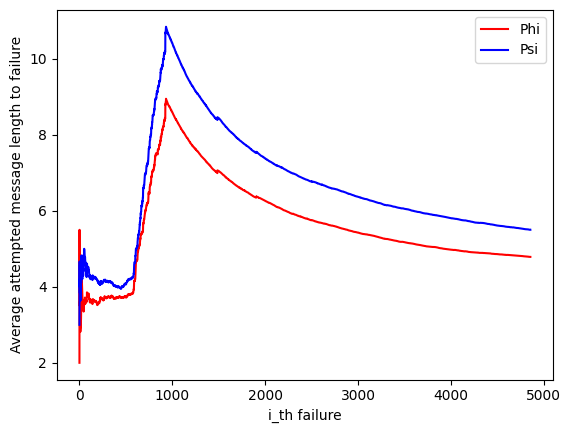

Phi: Average attempted message length to failure 4.787273476112026
Psi: Average attempted message length to failure 5.5014415156507415


In [486]:
agents = multiplemab1_sim.agents
mean_flength_phi = agents[0].mean_failed_length
mean_flength_psi = agents[1].mean_failed_length
plt.plot(range(len(mean_flength_phi)), mean_flength_phi, label='Phi', color='red')
plt.plot(range(len(mean_flength_psi)), mean_flength_psi, label='Psi', color='blue')
plt.xlabel("i_th failure")
plt.ylabel("Average attempted message length to failure")
plt.legend(loc='upper right')
plt.show()
print("Phi: Average attempted message length to failure", np.average(agents[0].failed_length))
print("Psi: Average attempted message length to failure",np.average(agents[1].failed_length))

#### 6. Variation from 5. where rewards are based on message sequence length
- The shorter the attempted message response sequence length is, the higher the reward
- Therefore, agent will be pushed faster towards using the best strategy
- The rest details is the same with 5.

In [480]:
class MultipleBanditAgent2:

    def __init__(self, internal_latency, objective, mab_dict):
        self.internal_latency = internal_latency
        self.objective = objective
        self.mab_dict = mab_dict
        self.attempt = []
        self.success_length = []
        self.failed_length = []
        self.mean_success_length = []
        self.mean_failed_length = []
        self.times_matched = 0

    def get_message(self, phi_matched, psi_matched, current_state):
        if (self.objective == "phi"):
            self.times_matched = phi_matched
        elif (self.objective == "psi"):
            self.times_matched = psi_matched

        # Choose MAB to predict based on current state
        arm_picked = self.mab_dict[current_state].predict()
        self.attempt.append((current_state, arm_picked))

        # self.message_sent.append(arm_picked)
        return arms_to_message[arm_picked]
    
    def learn(self, phi_matched, psi_matched, current_state):
        # print(self.objective, self.attempt)
        change = 0
        if (self.objective == "phi"):
            change = phi_matched - self.times_matched
        if (self.objective == "psi"):
            change = psi_matched - self.times_matched

        if (change == 1):
            # Success attempt
            for state_msg in self.attempt:
                self.mab_dict[state_msg[0]].partial_fit([state_msg[1]], [10/len(self.attempt)]) # <-- !! Variation
            self.success_length.append(len(self.attempt))
            self.mean_success_length.append(np.mean(self.success_length))
            self.attempt.clear()
        elif (current_state == (False, False)):
            # Failed attempt
            for state_msg in self.attempt:
                self.mab_dict[state_msg[0]].partial_fit([state_msg[1]], [0])
            self.failed_length.append(len(self.attempt))
            self.mean_failed_length.append(np.mean(self.failed_length))
            self.attempt.clear()

    def explain(self):
        print(" - " + self.objective + " agent bandits expectation")
        for states in self.mab_dict:
            print("  - Bandit for current state = " + stringify_state[states])
            print(self.mab_dict[states]._imp.arm_to_expectation)


            

In [442]:
def sim_mab3(max_time, learn_policy=LearningPolicy.Softmax(tau=0.3)):

    arms = ['A->T', 'A->F', 'B->T', 'B->F']

    # φ: (FF) -> F(TF) -> X(TT)
    # s = [(0, False), (1, False), (0, True), (1, True), (0, False), (1, False)]
    # F? -> FF -> TF -> TT -> FT -> FF

    mab1 = MAB(arms, learn_policy)
    mab1.fit(arms, [0, 10, 0, 0]) # (True, True)
    mab2 = MAB(arms, learn_policy)
    mab2.fit(arms, [0, 0, 10, 0]) # (True, False)
    mab3 = MAB(arms, learn_policy)
    mab3.fit(arms, [0, 0, 0, 10]) # (False, True)
    mab4 = MAB(arms, learn_policy)
    mab4.fit(arms, [10, 0, 0, 0]) # (False, False)

    # ψ: (FF) -> X(FT) -> F(TT)
    # s = [(0, False), (1, False), (1, True), (0, True), (0, False), (1, False)]
    # ?? -> F? -> FF -> FT -> TT -> FT -> FF
    mab5 = MAB(arms, learn_policy)
    mab5.fit(arms, [0, 10, 0, 0]) # (True, True)
    mab6 = MAB(arms, learn_policy)
    mab6.fit(arms, [0, 10, 0, 0]) # (True, False)
    mab7 = MAB(arms, learn_policy)
    mab7.fit(arms, [10, 0, 0, 0]) # (False, True)
    mab8 = MAB(arms, learn_policy)
    mab8.fit(arms, [0, 0, 10, 0]) # (False, False)

    mab_dict_1 = {(True, True): mab1, (True, False): mab2, (False, True): mab3, (False, False): mab4}
    mab_dict_2 = {(True, True): mab5, (True, False): mab6, (False, True): mab7, (False, False): mab8}

    multibandit2_agent1 = MultipleBanditAgent2(0, "phi", mab_dict_1)
    multibandit2_agent2 = MultipleBanditAgent2(0, "psi", mab_dict_2)

    game = IteratedBooleanGame((False, False))
    game.add_agent(multibandit2_agent1)
    game.add_agent(multibandit2_agent2)
    game.simulate(max_time=max_time)
    return game

* Learning policy comparison

### Running Iterated Boolean Game Simulation ###
> 0% simulated
> 10% simulated
> 20% simulated
> 30% simulated
> 40% simulated
> 50% simulated
> 60% simulated
> 70% simulated
> 80% simulated
> 90% simulated
> Finished simulation
##############################
### Running Iterated Boolean Game Simulation ###
> 0% simulated
> 10% simulated
> 20% simulated
> 30% simulated
> 40% simulated
> 50% simulated
> 60% simulated
> 70% simulated
> 80% simulated
> 90% simulated
> Finished simulation
##############################
### Running Iterated Boolean Game Simulation ###
> 0% simulated
> 10% simulated
> 20% simulated
> 30% simulated
> 40% simulated
> 50% simulated
> 60% simulated
> 70% simulated
> 80% simulated
> 90% simulated
> Finished simulation
##############################
### Running Iterated Boolean Game Simulation ###
> 0% simulated
> 10% simulated
> 20% simulated
> 30% simulated
> 40% simulated
> 50% simulated
> 60% simulated
> 70% simulated
> 80% simulated
> 90% simulated
> Finishe

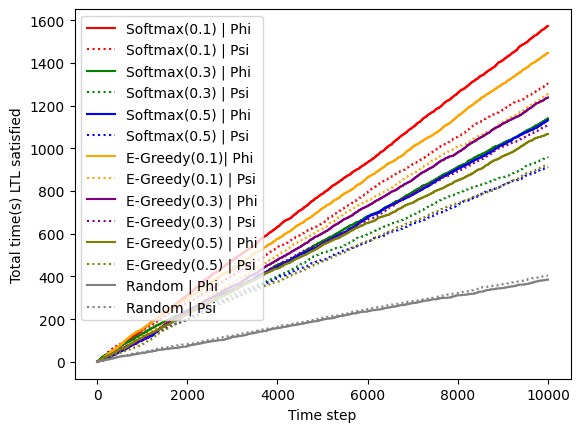

In [ ]:
max_time = 10000

test1 = sim_mab3(max_time=max_time, learn_policy=LearningPolicy.Softmax(tau=0.1))
test2 = sim_mab3(max_time=max_time, learn_policy=LearningPolicy.Softmax(tau=0.3))
test3 = sim_mab3(max_time=max_time, learn_policy=LearningPolicy.Softmax(tau=0.5))
test4 = sim_mab3(max_time=max_time, learn_policy=LearningPolicy.EpsilonGreedy(epsilon=0.1))
test5 = sim_mab3(max_time=max_time, learn_policy=LearningPolicy.EpsilonGreedy(epsilon=0.3))
test6 = sim_mab3(max_time=max_time, learn_policy=LearningPolicy.EpsilonGreedy(epsilon=0.5))
test_base = sim_mab3(max_time=max_time, learn_policy=LearningPolicy.Random())

x = range(max_time + 1)
plt.plot(x, test1.cumu_phi_matched, label='Softmax(0.1) | Phi', color='red',)
plt.plot(x, test1.cumu_psi_matched, label='Softmax(0.1) | Psi', color='red', linestyle = 'dotted')
plt.plot(x, test2.cumu_phi_matched, label='Softmax(0.3) | Phi', color='green',)
plt.plot(x, test2.cumu_psi_matched, label='Softmax(0.3) | Psi', color='green', linestyle = 'dotted')
plt.plot(x, test3.cumu_phi_matched, label='Softmax(0.5) | Phi', color='blue',)
plt.plot(x, test3.cumu_psi_matched, label='Softmax(0.5) | Psi', color='blue', linestyle = 'dotted')
plt.plot(x, test4.cumu_phi_matched, label='E-Greedy(0.1)| Phi', color='orange',)
plt.plot(x, test4.cumu_psi_matched, label='E-Greedy(0.1) | Psi', color='orange', linestyle = 'dotted')
plt.plot(x, test5.cumu_phi_matched, label='E-Greedy(0.3) | Phi', color='purple',)
plt.plot(x, test5.cumu_psi_matched, label='E-Greedy(0.3) | Psi', color='purple', linestyle = 'dotted')
plt.plot(x, test6.cumu_phi_matched, label='E-Greedy(0.5) | Phi', color='olive',)
plt.plot(x, test6.cumu_psi_matched, label='E-Greedy(0.5) | Psi', color='olive', linestyle = 'dotted')
plt.plot(x, test_base.cumu_phi_matched, label='Random | Phi', color='gray',)
plt.plot(x, test_base.cumu_psi_matched, label='Random | Psi', color='gray', linestyle = 'dotted')

plt.xlabel("Time step")
plt.ylabel("Total time(s) LTL satisfied")
plt.legend(loc='upper left')
plt.show()

* Simulation

### Running Iterated Boolean Game Simulation ###
> 0% simulated
> 2% simulated
> 4% simulated
> 6% simulated
> 8% simulated
> 10% simulated
> 12% simulated
> 14% simulated
> 16% simulated
> 18% simulated
> 20% simulated
> 22% simulated
> 24% simulated
> 26% simulated
> 28% simulated
> 30% simulated
> 32% simulated
> 34% simulated
> 36% simulated
> 38% simulated
> 40% simulated
> 42% simulated
> 44% simulated
> 46% simulated
> 48% simulated
> 50% simulated
> 52% simulated
> 54% simulated
> 56% simulated
> 57% simulated
> 60% simulated
> 62% simulated
> 64% simulated
> 66% simulated
> 68% simulated
> 70% simulated
> 72% simulated
> 74% simulated
> 76% simulated
> 78% simulated
> 80% simulated
> 82% simulated
> 84% simulated
> 86% simulated
> 88% simulated
> 90% simulated
> 92% simulated
> 94% simulated
> 96% simulated
> 98% simulated
> Finished simulation
##############################
### Explaining Latest Iterated Boolean Game Simulation ###


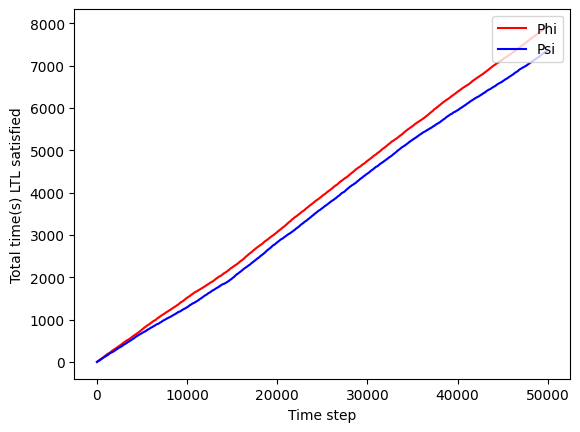

Total Phi satisfaction: 7941
Total Psi satisfaction: 7364
 - phi agent bandits expectation
  - Bandit for current state = (T, T)
{'A->T': 2.174943411630751e-05, 'A->F': 0.04190885666933166, 'B->T': 0.6629698632061768, 'B->F': 0.2950995306903752}
  - Bandit for current state = (T, F)
{'A->T': 6.236433216674653e-05, 'A->F': 9.668874757132248e-07, 'B->T': 0.9999357018928817, 'B->F': 9.668874757132248e-07}
  - Bandit for current state = (F, T)
{'A->T': 2.797684920805209e-05, 'A->F': 2.797684920805209e-05, 'B->T': 2.797684920805209e-05, 'B->F': 0.9999160694523758}
  - Bandit for current state = (F, F)
{'A->T': 1.0, 'A->F': 3.2968607470539745e-22, 'B->T': 3.2968607470539745e-22, 'B->F': 3.2968607470539745e-22}
 - psi agent bandits expectation
  - Bandit for current state = (T, T)
{'A->T': 0.1992188390552092, 'A->F': 0.08705842973945517, 'B->T': 0.1961863023912892, 'B->F': 0.5175364288140465}
  - Bandit for current state = (T, F)
{'A->T': 0.00027431867424256885, 'A->F': 0.9995588536387606, 'B

In [487]:
max_time = 50000
multiplemab2_sim = sim_mab3(max_time=max_time, learn_policy=LearningPolicy.Softmax(tau=0.1))
multiplemab2_sim.explain()

* Analysis of message length on success attempts

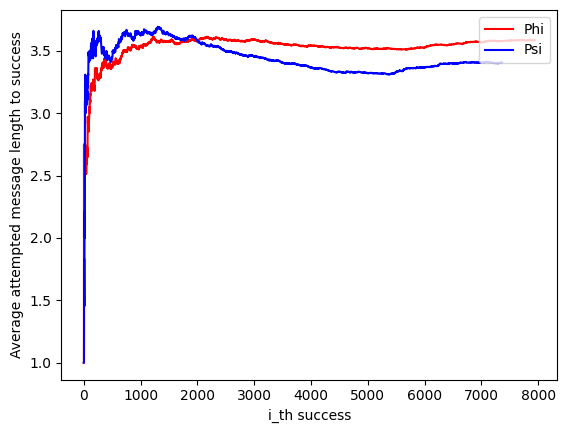

Phi: Average attempted message length to success  3.583679637325274
Psi: Average attempted message length to success 3.4056219445953286


In [492]:
agents = multiplemab2_sim.agents
mean_slength_phi = agents[0].mean_success_length
mean_slength_psi = agents[1].mean_success_length

plt.plot(range(len(mean_slength_phi)), mean_slength_phi, label='Phi', color='red')
plt.plot(range(len(mean_slength_psi)), mean_slength_psi, label='Psi', color='blue')
plt.xlabel("i_th success")
plt.ylabel("Average attempted message length to success")
plt.legend(loc='upper right')
plt.show()
print("Phi: Average attempted message length to success ", np.average(agents[0].success_length))
print("Psi: Average attempted message length to success",np.average(agents[1].success_length))

* Analysis of message length on failed attempts

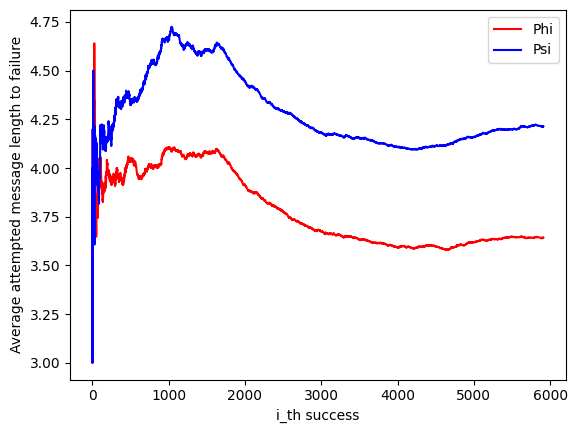

Phi: Average attempted message length to failure 3.643159140876036
Psi: Average attempted message length to failure 4.214104515474379


In [493]:
agents = multiplemab2_sim.agents
mean_flength_phi = agents[0].mean_failed_length
mean_flength_psi = agents[1].mean_failed_length
plt.plot(range(len(mean_flength_phi)), mean_flength_phi, label='Phi', color='red')
plt.plot(range(len(mean_flength_psi)), mean_flength_psi, label='Psi', color='blue')
plt.xlabel("i_th success")
plt.ylabel("Average attempted message length to failure")
plt.legend(loc='upper right')
plt.show()
print("Phi: Average attempted message length to failure", np.average(agents[0].failed_length))
print("Psi: Average attempted message length to failure",np.average(agents[1].failed_length))

#### 7. Variation from 5. where agent can choose NOT to send message

In [472]:
class MultipleBanditAgent3:

    # φ: (FF) -> F(TF) -> X(TT)
    # s = [(0, False), (1, False), (0, True), (1, True), (0, False), (1, False)]
    # {(True, True): mab1, (True, False): mab2, (False, True): mab3, (False, False): mab4}
    def __init__(self, internal_latency, objective, mab_dict):
        self.internal_latency = internal_latency
        self.objective = objective
        self.mab_dict = mab_dict
        self.attempt = []
        self.success_length = []
        self.failed_length = []
        self.mean_success_length = []
        self.mean_failed_length = []
        self.times_matched = 0

    def get_message(self, phi_matched, psi_matched, current_state):
        if (self.objective == "phi"):
            self.times_matched = phi_matched
        elif (self.objective == "psi"):
            self.times_matched = psi_matched

        # Choose MAB to predict based on current state
        arm_picked = self.mab_dict[current_state].predict()

        if arm_picked:
            self.attempt.append((current_state, arm_picked))
            
        # self.message_sent.append(arm_picked)
        return arms_to_message[arm_picked]
    
    def learn(self, phi_matched, psi_matched, current_state):
        # print(self.objective, self.attempt)
        change = 0
        if (self.objective == "phi"):
            change = phi_matched - self.times_matched
        if (self.objective == "psi"):
            change = psi_matched - self.times_matched

        if (change == 1):
            # Success
            for state_msg in self.attempt:
                self.mab_dict[state_msg[0]].partial_fit([state_msg[1]], [10/len(self.attempt)])
            self.success_length.append(len(self.attempt))
            self.mean_success_length.append(np.mean(self.success_length))

            self.attempt.clear()
        elif (current_state == (False, False) or len(self.attempt) > 10):
            # Fail
            for state_msg in self.attempt:
                self.mab_dict[state_msg[0]].partial_fit([state_msg[1]], [0])
            self.failed_length.append(len(self.attempt))
            self.mean_failed_length.append(np.mean(self.success_length))
            self.attempt.clear()

    def explain(self):
        print(" - " + self.objective + " agent bandits expectation")
        for states in self.mab_dict:
            print("  - Bandit for current state = " + stringify_state[states])
            print(self.mab_dict[states]._imp.arm_to_expectation)


            

    
            # self.mab.partial_fit([self.message_sent[-1]], [phi_matched - self.times_matched])
        # elif (self.objective == "psi"):
        #     self.mab.partial_fit([self.message_sent[-1]], [psi_matched - self.times_matched])

In [446]:
def sim_mab4(max_time, learn_policy=LearningPolicy.Softmax(tau=0.3)):

    arms = ['A->T', 'A->F', 'B->T', 'B->F', 'Idle']

    # φ: (FF) -> F(TF) -> X(TT)
    # s = [(0, False), (1, False), (0, True), (1, True), (0, False), (1, False)]
    # F? -> FF -> TF -> TT -> FT -> FF

    mab1 = MAB(arms, learn_policy)
    mab1.fit(arms, [0, 10, 0, 0, 0]) # (True, True)
    mab2 = MAB(arms, learn_policy)
    mab2.fit(arms, [0, 0, 10, 0, 0]) # (True, False)
    mab3 = MAB(arms, learn_policy)
    mab3.fit(arms, [0, 0, 0, 10, 0]) # (False, True)
    mab4 = MAB(arms, learn_policy)
    mab4.fit(arms, [10, 0, 0, 0, 0]) # (False, False)

    # ψ: (FF) -> X(FT) -> F(TT)
    # s = [(0, False), (1, False), (1, True), (0, True), (0, False), (1, False)]
    # ?? -> F? -> FF -> FT -> TT -> FT -> FF
    mab5 = MAB(arms, learn_policy)
    mab5.fit(arms, [0, 10, 0, 0, 0]) # (True, True)
    mab6 = MAB(arms, learn_policy)
    mab6.fit(arms, [0, 10, 0, 0, 0]) # (True, False)
    mab7 = MAB(arms, learn_policy)
    mab7.fit(arms, [10, 0, 0, 0, 0]) # (False, True)
    mab8 = MAB(arms, learn_policy)
    mab8.fit(arms, [0, 0, 10, 0, 0]) # (False, False)

    mab_dict_1 = {(True, True): mab1, (True, False): mab2, (False, True): mab3, (False, False): mab4}
    mab_dict_2 = {(True, True): mab5, (True, False): mab6, (False, True): mab7, (False, False): mab8}

    multibandit3_agent1 = MultipleBanditAgent3(0, "phi", mab_dict_1)
    multibandit3_agent2 = MultipleBanditAgent3(0, "psi", mab_dict_2)

    game = IteratedBooleanGame((False, False))
    game.add_agent(multibandit3_agent1)
    game.add_agent(multibandit3_agent2)
    game.simulate(max_time=max_time)

    return game

* Learning policy comparison

### Running Iterated Boolean Game Simulation ###
> 0% simulated
> 10% simulated
> 20% simulated
> 30% simulated
> 40% simulated
> 50% simulated
> 60% simulated
> 70% simulated
> 80% simulated
> 90% simulated
> Finished simulation
##############################
### Running Iterated Boolean Game Simulation ###
> 0% simulated
> 10% simulated
> 20% simulated
> 30% simulated
> 40% simulated
> 50% simulated
> 60% simulated
> 70% simulated
> 80% simulated
> 90% simulated
> Finished simulation
##############################
### Running Iterated Boolean Game Simulation ###
> 0% simulated
> 10% simulated
> 20% simulated
> 30% simulated
> 40% simulated
> 50% simulated
> 60% simulated
> 70% simulated
> 80% simulated
> 90% simulated
> Finished simulation
##############################
### Running Iterated Boolean Game Simulation ###
> 0% simulated
> 10% simulated
> 20% simulated
> 30% simulated
> 40% simulated
> 50% simulated
> 60% simulated
> 70% simulated
> 80% simulated
> 90% simulated
> Finishe

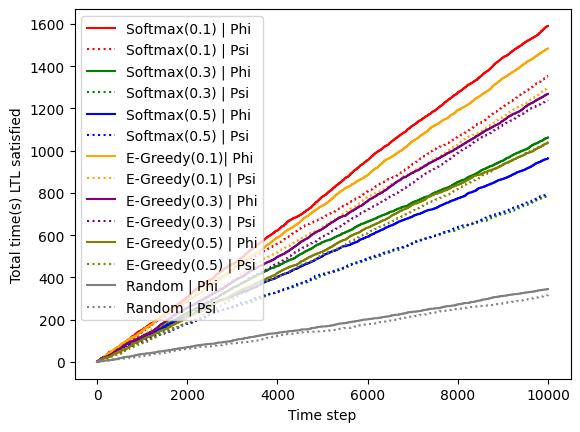

In [495]:
max_time = 10000

test1 = sim_mab4(max_time=max_time, learn_policy=LearningPolicy.Softmax(tau=0.1))
test2 = sim_mab4(max_time=max_time, learn_policy=LearningPolicy.Softmax(tau=0.3))
test3 = sim_mab4(max_time=max_time, learn_policy=LearningPolicy.Softmax(tau=0.5))
test4 = sim_mab4(max_time=max_time, learn_policy=LearningPolicy.EpsilonGreedy(epsilon=0.1))
test5 = sim_mab4(max_time=max_time, learn_policy=LearningPolicy.EpsilonGreedy(epsilon=0.3))
test6 = sim_mab4(max_time=max_time, learn_policy=LearningPolicy.EpsilonGreedy(epsilon=0.5))
test_base = sim_mab4(max_time=max_time, learn_policy=LearningPolicy.Random())

x = range(max_time + 1)
plt.plot(x, test1.cumu_phi_matched, label='Softmax(0.1) | Phi', color='red',)
plt.plot(x, test1.cumu_psi_matched, label='Softmax(0.1) | Psi', color='red', linestyle = 'dotted')
plt.plot(x, test2.cumu_phi_matched, label='Softmax(0.3) | Phi', color='green',)
plt.plot(x, test2.cumu_psi_matched, label='Softmax(0.3) | Psi', color='green', linestyle = 'dotted')
plt.plot(x, test3.cumu_phi_matched, label='Softmax(0.5) | Phi', color='blue',)
plt.plot(x, test3.cumu_psi_matched, label='Softmax(0.5) | Psi', color='blue', linestyle = 'dotted')
plt.plot(x, test4.cumu_phi_matched, label='E-Greedy(0.1)| Phi', color='orange',)
plt.plot(x, test4.cumu_psi_matched, label='E-Greedy(0.1) | Psi', color='orange', linestyle = 'dotted')
plt.plot(x, test5.cumu_phi_matched, label='E-Greedy(0.3) | Phi', color='purple',)
plt.plot(x, test5.cumu_psi_matched, label='E-Greedy(0.3) | Psi', color='purple', linestyle = 'dotted')
plt.plot(x, test6.cumu_phi_matched, label='E-Greedy(0.5) | Phi', color='olive',)
plt.plot(x, test6.cumu_psi_matched, label='E-Greedy(0.5) | Psi', color='olive', linestyle = 'dotted')
plt.plot(x, test_base.cumu_phi_matched, label='Random | Phi', color='gray',)
plt.plot(x, test_base.cumu_psi_matched, label='Random | Psi', color='gray', linestyle = 'dotted')

plt.xlabel("Time step")
plt.ylabel("Total time(s) LTL satisfied")
plt.legend(loc='upper left')
plt.show()

* Simulation

### Running Iterated Boolean Game Simulation ###
> 0% simulated


/Users/ttontoey/Documents/Indiv/.venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ttontoey/Documents/Indiv/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


> 2% simulated
> 4% simulated
> 6% simulated
> 8% simulated
> 10% simulated
> 12% simulated
> 14% simulated
> 16% simulated
> 18% simulated
> 20% simulated
> 22% simulated
> 24% simulated
> 26% simulated
> 28% simulated
> 30% simulated
> 32% simulated
> 34% simulated
> 36% simulated
> 38% simulated
> 40% simulated
> 42% simulated
> 44% simulated
> 46% simulated
> 48% simulated
> 50% simulated
> 52% simulated
> 54% simulated
> 56% simulated
> 57% simulated
> 60% simulated
> 62% simulated
> 64% simulated
> 66% simulated
> 68% simulated
> 70% simulated
> 72% simulated
> 74% simulated
> 76% simulated
> 78% simulated
> 80% simulated
> 82% simulated
> 84% simulated
> 86% simulated
> 88% simulated
> 90% simulated
> 92% simulated
> 94% simulated
> 96% simulated
> 98% simulated
> Finished simulation
##############################
### Explaining Latest Iterated Boolean Game Simulation ###


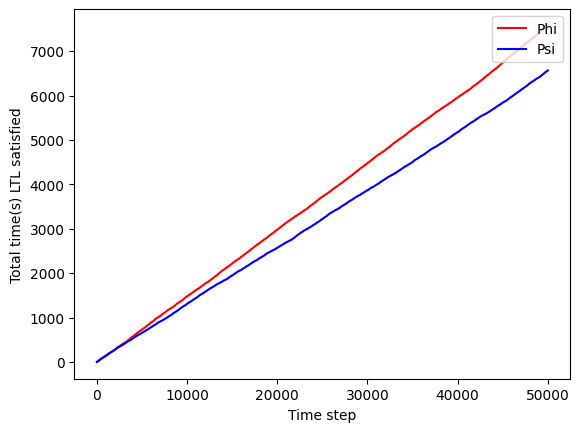

Total Phi satisfaction: 7567
Total Psi satisfaction: 6564
 - phi agent bandits expectation
  - Bandit for current state = (T, T)
{'A->T': 0.07102109598645506, 'A->F': 0.2605302532690392, 'B->T': 0.0001149398247997862, 'B->F': 0.5572085081686675, 'Idle': 0.11112520275103852}
  - Bandit for current state = (T, F)
{'A->T': 4.817190362620125e-07, 'A->F': 4.817190362620125e-07, 'B->T': 0.9999980731238547, 'B->F': 4.817190362620125e-07, 'Idle': 4.817190362620125e-07}
  - Bandit for current state = (F, T)
{'A->T': 4.560046392694513e-05, 'A->F': 4.560046392694513e-05, 'B->T': 4.560046392694513e-05, 'B->F': 0.9998175981442923, 'Idle': 4.560046392694513e-05}
  - Bandit for current state = (F, F)
{'A->T': 1.0, 'A->F': 3.923387040209656e-22, 'B->T': 3.923387040209656e-22, 'B->F': 3.923387040209656e-22, 'Idle': 3.923387040209656e-22}
 - psi agent bandits expectation
  - Bandit for current state = (T, T)
{'A->T': 0.16171973765438857, 'A->F': 0.17273018391106215, 'B->T': 0.328931791174033, 'B->F': 0.

In [488]:
max_time = 50000
multiplemab3_sim = sim_mab4(max_time=max_time, learn_policy=LearningPolicy.Softmax(tau=0.1))
multiplemab3_sim.explain()

* Analysis of message length on success attempts

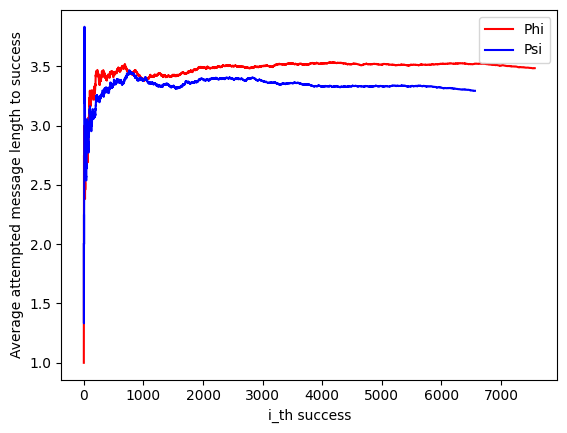

Phi: Average attempted message length to success  3.4843398969208406
Psi: Average attempted message length to success 3.2932663010359535


In [490]:
agents = multiplemab3_sim.agents
mean_slength_phi = agents[0].mean_success_length
mean_slength_psi = agents[1].mean_success_length


plt.plot(range(len(mean_slength_phi)), mean_slength_phi, label='Phi', color='red')
plt.plot(range(len(mean_slength_psi)), mean_slength_psi, label='Psi', color='blue')
plt.xlabel("i_th success")
plt.ylabel("Average attempted message length to success")
plt.legend(loc='upper right')
plt.show()
print("Phi: Average attempted message length to success ", np.average(agents[0].success_length))
print("Psi: Average attempted message length to success",np.average(agents[1].success_length))

* Analysis of message length on failed attempts

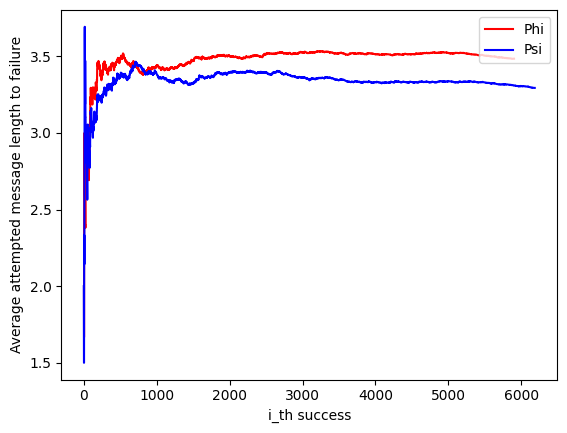

Phi: Average attempted message length to failure 4.005083884087443
Psi: Average attempted message length to failure 4.588843977364592


In [491]:
agents = multiplemab3_sim.agents
mean_flength_phi = agents[0].mean_failed_length
mean_flength_psi = agents[1].mean_failed_length
plt.plot(range(len(mean_flength_phi)), mean_flength_phi, label='Phi', color='red')
plt.plot(range(len(mean_flength_psi)), mean_flength_psi, label='Psi', color='blue')
plt.xlabel("i_th success")
plt.ylabel("Average attempted message length to failure")
plt.legend(loc='upper right')
plt.show()
print("Phi: Average attempted message length to failure", np.average(agents[0].failed_length))
print("Psi: Average attempted message length to failure",np.average(agents[1].failed_length))

#### 8. Sixteen bandits each with four arms

In [460]:
class MultipleBanditAgent4:


    # φ: (FF) -> F(TF) -> X(TT)
    # s = [(0, False), (1, False), (0, True), (1, True), (0, False), (1, False)]
    # {(True, True): mab1, (True, False): mab2, (False, True): mab3, (False, False): mab4}
    def __init__(self, internal_latency, objective, mab_dict):
        self.internal_latency = internal_latency
        self.objective = objective
        self.mab_dict = mab_dict
        self.attempt = [] # Each attempt = ((Previous Response, Current State), Response)
        self.success_length = []
        self.failed_length = []
        self.mean_success_length = []
        self.mean_failed_length = []
        self.times_matched = 0

    def get_message(self, phi_matched, psi_matched, current_state):
        if (self.objective == "phi"):
            self.times_matched = phi_matched
        elif (self.objective == "psi"):
            self.times_matched = psi_matched

        # Choose MAB to predict based on current state
        if (len(self.attempt) == 0):
            if (self.objective == "phi"):
                prev_response = (1, True)
            elif (self.objective == "psi"):
                prev_response = (0, True)
        else:
            prev_response = arms_to_message[self.attempt[-1][1]]
        
        arm_picked = self.mab_dict[(prev_response, current_state)].predict()
        response = arms_to_message[arm_picked]
        self.attempt.append(((prev_response, current_state), arm_picked))
        
        # self.message_sent.append(arm_picked)
        return response
    
    def learn(self, phi_matched, psi_matched, current_state):
        # print(self.objective, self.attempt)
        # print(self.objective, self.attempt)
        change = 0
        if (self.objective == "phi"):
            change = phi_matched - self.times_matched
        if (self.objective == "psi"):
            change = psi_matched - self.times_matched

        if (change == 1):
            # Success
            for attempt in self.attempt:
                # Each attempt = ((Previous Response, Current State), Response)
                prev_response = attempt[0][0]
                current_state = attempt[0][1]
                response = attempt[1]
                self.mab_dict[(prev_response, current_state)].partial_fit([response], [10/len(attempt)])
            self.success_length.append(len(self.attempt))
            self.mean_success_length.append(np.mean(self.success_length))
            self.attempt.clear()
        elif (current_state == (False, False) or len(self.attempt) > 100000):
            # Fail
            for attempt in self.attempt:
                prev_response = attempt[0][0]
                current_state = attempt[0][1]
                response = attempt[1]
                # print(arms_to_message[response])
                self.mab_dict[(prev_response, current_state)].partial_fit([response], [0])
            self.failed_length.append(len(self.attempt))
            self.mean_failed_length.append(np.mean(self.failed_length))
            self.attempt.clear()
    
    def explain(self):
        print(" - " + self.objective + " agent bandits expectation")
        for key in self.mab_dict:
            print("  - Bandit for current state = " + str(key))
            print(self.mab_dict[key]._imp.arm_to_expectation)

In [ ]:
# All possible keys in the MAB dictionary


# Previous Attempt, Current State
# (0, False) FF
# (0, False) FT
# (0, False) TF
# (0, False) TT
# (0, True) FF
# (0, True) FT
# (0, True) TF
# (0, True) TT
# (1, False) FF
# (1, False) FT
# (1, False) TF
# (1, False) TT
# (1, True) FF
# (1, True) FT
# (1, True) TF

In [451]:
def sim_mab5(max_time, learn_policy=LearningPolicy.Softmax(tau=0.3)):

    arms_to_message = {'A->T': (0, True), 'A->F': (0, False), 'B->T': (1, True), 'B->F': (1, False), "Idle": None}
    message_to_arms = {(0, True): 'A->T', (0, False): 'A->F' , (1, True): 'B->T', (1, False): 'B->F' ,  None: "Idle"}
    arms = ['A->T', 'A->F', 'B->T', 'B->F']


    # (1, True) TT
    # φ: (FF) -> F(TF) -> X(TT)
    # s = [(0, False), (1, False), (0, True), (1, True), (0, False), (1, False)]
    # F? -> FF -> TF -> TT -> FT -> FF
    mab_dict_1 = {}
    for i in [(False, False), (False, True), (True, False), (True, True)]:
        mab = MAB(arms, learn_policy)
        mab.fit(arms, [0, 0, 0, 10]) # (1, False) B->F
        mab_dict_1[((0, False), i)] = mab #
    for i in [(False, False), (False, True), (True, False), (True, True)]:
        mab = MAB(arms, learn_policy)
        mab.fit(arms, [0, 0, 10, 0]) # (1, True) B->T
        mab_dict_1[((0, True), i)] = mab
    for i in [(False, False), (False, True), (True, False), (True, True)]:
        mab = MAB(arms, learn_policy)
        mab.fit(arms, [10, 0, 0, 0]) # (0, True) A->T
        mab_dict_1[((1, False), i)] = mab
    for i in [(False, False), (False, True), (True, False), (True, True)]:
        mab = MAB(arms, learn_policy)
        mab.fit(arms, [0, 10, 0, 0]) # (0, False) A->F
        mab_dict_1[((1, True), i)] = mab

    # ψ: (FF) -> X(FT) -> F(TT)
    # s = [(0, False), (1, False), (1, True), (0, True), (0, False), (1, False)]
    # ?? -> F? -> FF -> FT -> TT -> FT -> FF
    mab_dict_2 = {}
    for i in [(False, False), (False, True), (True, False), (True, True)]:
        mab = MAB(arms, learn_policy)
        mab.fit(arms, [0, 0, 0, 10]) # (1, False) B->F
        mab_dict_2[((0, False), i)] = mab #
    for i in [(False, False), (False, True), (True, False), (True, True)]:
        mab = MAB(arms, learn_policy)
        mab.fit(arms, [0, 10, 0, 0]) # (1, True) A->F
        mab_dict_2[((0, True), i)] = mab
    for i in [(False, False), (False, True), (True, False), (True, True)]:
        mab = MAB(arms, learn_policy)
        mab.fit(arms, [0, 0, 10, 0]) # (0, True) B->T
        mab_dict_2[((1, False), i)] = mab
    for i in [(False, False), (False, True), (True, False), (True, True)]:
        mab = MAB(arms, learn_policy)
        mab.fit(arms, [0, 0, 0, 10]) # (0, False) B->F
        mab_dict_2[((1, True), i)] = mab

    multibandit4_agent1 = MultipleBanditAgent4(0, "phi", mab_dict_1)
    multibandit4_agent2 = MultipleBanditAgent4(0, "psi", mab_dict_2)
    game = IteratedBooleanGame((False, False))
    game.add_agent(multibandit4_agent1)
    game.add_agent(multibandit4_agent2)
    game.simulate(max_time=max_time)

    return game

* Learning policy comparison

### Running Iterated Boolean Game Simulation ###
> 0% simulated
> 10% simulated
> 20% simulated
> 30% simulated
> 40% simulated
> 50% simulated
> 60% simulated
> 70% simulated
> 80% simulated
> 90% simulated
> Finished simulation
##############################
### Running Iterated Boolean Game Simulation ###
> 0% simulated
> 10% simulated
> 20% simulated
> 30% simulated
> 40% simulated
> 50% simulated
> 60% simulated
> 70% simulated
> 80% simulated
> 90% simulated
> Finished simulation
##############################
### Running Iterated Boolean Game Simulation ###
> 0% simulated
> 10% simulated
> 20% simulated
> 30% simulated
> 40% simulated
> 50% simulated
> 60% simulated
> 70% simulated
> 80% simulated
> 90% simulated
> Finished simulation
##############################
### Running Iterated Boolean Game Simulation ###
> 0% simulated
> 10% simulated
> 20% simulated
> 30% simulated
> 40% simulated
> 50% simulated
> 60% simulated
> 70% simulated
> 80% simulated
> 90% simulated
> Finishe

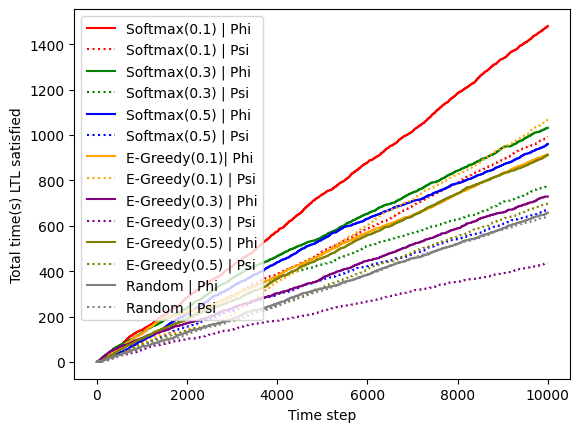

In [ ]:
max_time = 10000

test1 = sim_mab5(max_time=max_time, learn_policy=LearningPolicy.Softmax(tau=0.1))
test2 = sim_mab5(max_time=max_time, learn_policy=LearningPolicy.Softmax(tau=0.3))
test3 = sim_mab5(max_time=max_time, learn_policy=LearningPolicy.Softmax(tau=0.5))
test4 = sim_mab5(max_time=max_time, learn_policy=LearningPolicy.EpsilonGreedy(epsilon=0.1))
test5 = sim_mab5(max_time=max_time, learn_policy=LearningPolicy.EpsilonGreedy(epsilon=0.3))
test6 = sim_mab5(max_time=max_time, learn_policy=LearningPolicy.EpsilonGreedy(epsilon=0.5))
test_base = sim_mab5(max_time=max_time, learn_policy=LearningPolicy.Random())


x = range(max_time + 1)
plt.plot(x, test1.cumu_phi_matched, label='Softmax(0.1) | Phi', color='red',)
plt.plot(x, test1.cumu_psi_matched, label='Softmax(0.1) | Psi', color='red', linestyle = 'dotted')
plt.plot(x, test2.cumu_phi_matched, label='Softmax(0.3) | Phi', color='green',)
plt.plot(x, test2.cumu_psi_matched, label='Softmax(0.3) | Psi', color='green', linestyle = 'dotted')
plt.plot(x, test3.cumu_phi_matched, label='Softmax(0.5) | Phi', color='blue',)
plt.plot(x, test3.cumu_psi_matched, label='Softmax(0.5) | Psi', color='blue', linestyle = 'dotted')
plt.plot(x, test4.cumu_phi_matched, label='E-Greedy(0.1)| Phi', color='orange',)
plt.plot(x, test4.cumu_psi_matched, label='E-Greedy(0.1) | Psi', color='orange', linestyle = 'dotted')
plt.plot(x, test5.cumu_phi_matched, label='E-Greedy(0.3) | Phi', color='purple',)
plt.plot(x, test5.cumu_psi_matched, label='E-Greedy(0.3) | Psi', color='purple', linestyle = 'dotted')
plt.plot(x, test6.cumu_phi_matched, label='E-Greedy(0.5) | Phi', color='olive',)
plt.plot(x, test6.cumu_psi_matched, label='E-Greedy(0.5) | Psi', color='olive', linestyle = 'dotted')
plt.plot(x, test_base.cumu_phi_matched, label='Random | Phi', color='gray',)
plt.plot(x, test_base.cumu_psi_matched, label='Random | Psi', color='gray', linestyle = 'dotted')

plt.xlabel("Time step")
plt.ylabel("Total time(s) LTL satisfied")
plt.legend(loc='upper left')
plt.show()

* Simulation

### Running Iterated Boolean Game Simulation ###
> 0% simulated
> 2% simulated
> 4% simulated
> 6% simulated
> 8% simulated
> 10% simulated
> 12% simulated
> 14% simulated
> 16% simulated
> 18% simulated
> 20% simulated
> 22% simulated
> 24% simulated
> 26% simulated
> 28% simulated
> 30% simulated
> 32% simulated
> 34% simulated
> 36% simulated
> 38% simulated
> 40% simulated
> 42% simulated
> 44% simulated
> 46% simulated
> 48% simulated
> 50% simulated
> 52% simulated
> 54% simulated
> 56% simulated
> 57% simulated
> 60% simulated
> 62% simulated
> 64% simulated
> 66% simulated
> 68% simulated
> 70% simulated
> 72% simulated
> 74% simulated
> 76% simulated
> 78% simulated
> 80% simulated
> 82% simulated
> 84% simulated
> 86% simulated
> 88% simulated
> 90% simulated
> 92% simulated
> 94% simulated
> 96% simulated
> 98% simulated
> Finished simulation
##############################
### Explaining Latest Iterated Boolean Game Simulation ###


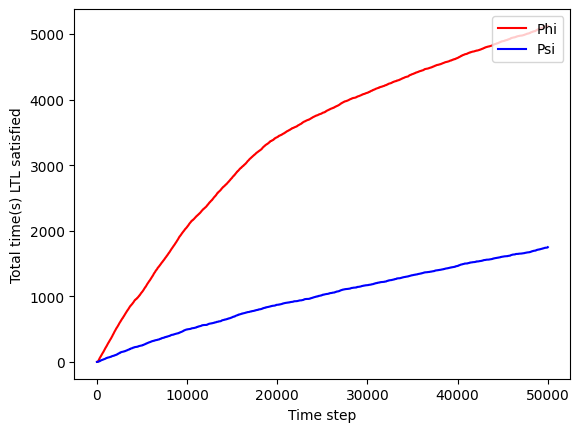

Total Phi satisfaction: 5123
Total Psi satisfaction: 1749
 - phi agent bandits expectation
  - Bandit for current state = ((0, False), (False, False))
{'A->T': 3.720075976020836e-44, 'A->F': 3.720075976020836e-44, 'B->T': 3.720075976020836e-44, 'B->F': 1.0}
  - Bandit for current state = ((0, False), (False, True))
{'A->T': 0.000592732475231492, 'A->F': 0.000592732475231492, 'B->T': 0.000592732475231492, 'B->F': 0.9982218025743055}
  - Bandit for current state = ((0, False), (True, False))
{'A->T': 3.2547703892441803e-06, 'A->F': 3.2547703892441803e-06, 'B->T': 3.2547703892441803e-06, 'B->F': 0.9999902356888323}
  - Bandit for current state = ((0, False), (True, True))
{'A->T': 0.000831690295382515, 'A->F': 0.000831690295382515, 'B->T': 0.000831690295382515, 'B->F': 0.9975049291138524}
  - Bandit for current state = ((0, True), (False, False))
{'A->T': 3.720075976020836e-44, 'A->F': 3.720075976020836e-44, 'B->T': 1.0, 'B->F': 3.720075976020836e-44}
  - Bandit for current state = ((0, T

In [498]:
max_time = 50000
multiplemab4_sim = sim_mab5(max_time=max_time, learn_policy=LearningPolicy.Softmax(tau=0.1))
multiplemab4_sim.explain()

* Analysis of message length on success attempts

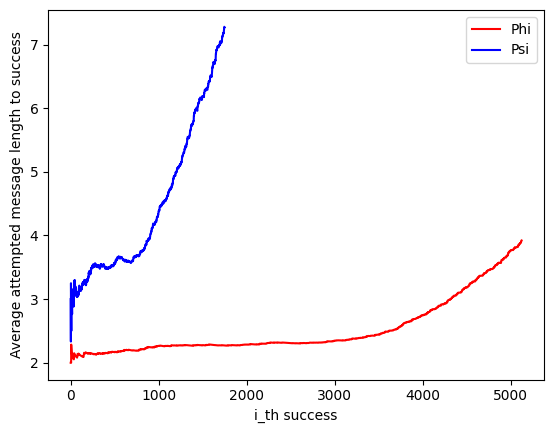

Phi: Average attempted message length to success  3.9213351551825104
Psi: Average attempted message length to success 7.270440251572327


In [500]:
agents = multiplemab4_sim.agents
mean_slength_phi = agents[0].mean_success_length
mean_slength_psi = agents[1].mean_success_length
plt.plot(range(len(mean_slength_phi)), mean_slength_phi, label='Phi', color='red')
plt.plot(range(len(mean_slength_psi)), mean_slength_psi, label='Psi', color='blue')
plt.xlabel("i_th success")
plt.ylabel("Average attempted message length to success")
plt.legend(loc='upper right')
plt.show()
print("Phi: Average attempted message length to success ", np.average(agents[0].success_length))
print("Psi: Average attempted message length to success",np.average(agents[1].success_length))

* Analysis of message length on failed attempts

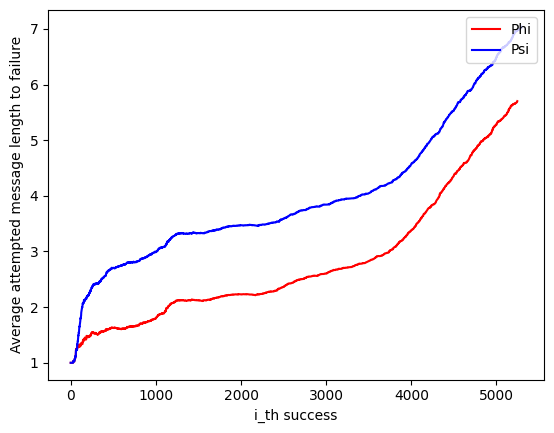

Phi: Average attempted message length to failure 5.701811248808389
Psi: Average attempted message length to failure 7.038519637462236


In [501]:
agents = multiplemab4_sim.agents
mean_flength_phi = agents[0].mean_failed_length
mean_flength_psi = agents[1].mean_failed_length
plt.plot(range(len(mean_flength_phi)), mean_flength_phi, label='Phi', color='red')
plt.plot(range(len(mean_flength_psi)), mean_flength_psi, label='Psi', color='blue')
plt.xlabel("i_th success")
plt.ylabel("Average attempted message length to failure")
plt.legend(loc='upper right')
plt.show()
print("Phi: Average attempted message length to failure", np.average(agents[0].failed_length))
print("Psi: Average attempted message length to failure",np.average(agents[1].failed_length))

## Code archive (Feel free to ignore me)

In [ ]:
random.randint(0, 9)

In [ ]:
# ['A->T', 'A->F', 'B->T', 'B->F']    
# φ: (FF) -> F(TF) -> X(TT)
# s = [(0, False), (1, False), (0, True), (1, True), (0, False), (1, False)]
# F? -> FF -> TF -> TT -> FT -> FF

# mab1 = MAB(arms, LearningPolicy.EpsilonGreedy(epsilon=0.6))
# mab1.fit(arms, [0, 10, 0, 0]) # (True, True)
# mab2 = MAB(arms, LearningPolicy.EpsilonGreedy(epsilon=0.6))
# mab2.fit(arms, [0, 0, 10, 0]) # (True, False)
# mab3 = MAB(arms, LearningPolicy.EpsilonGreedy(epsilon=0.6))
# mab3.fit(arms, [0, 0, 0, 10]) # (False, True)
# mab4 = MAB(arms, LearningPolicy.EpsilonGreedy(epsilon=0.6))
# mab4.fit(arms, [10, 0, 0, 0]) # (False, False)

# # ψ: (FF) -> X(FT) -> F(TT)
# # s = [(0, False), (1, False), (1, True), (0, True), (0, False), (1, False)]
# # ?? -> F? -> FF -> FT -> TT -> FT -> FF
# mab5 = MAB(arms, LearningPolicy.EpsilonGreedy(epsilon=0.6))
# mab5.fit(arms, [0, 10, 0, 0]) # (True, True)
# mab6 = MAB(arms, LearningPolicy.EpsilonGreedy(epsilon=0.6))
# mab6.fit(arms, [0, 10, 0, 0]) # (True, False)
# mab7 = MAB(arms, LearningPolicy.EpsilonGreedy(epsilon=0.6))
# mab7.fit(arms, [10, 0, 0, 0]) # (False, True)
# mab8 = MAB(arms, LearningPolicy.EpsilonGreedy(epsilon=0.6))
# mab8.fit(arms, [0, 0, 10, 0]) # (False, False)

In [ ]:
        # s = [(0, False), (1, False), (0, True), (1, True)]
        # return s[random.randint(0, 3)]
        # self.i += 1
        # s = [(0, False), (1, False), (0, True), (1, True), (0, False), (1, False)]
        # return s[self.i % 6]
        #####

In [ ]:
values = [5, 1, 3, 7, 4, 2]
heapq.heapify(values)
print(values)

In [ ]:
def test():
    print("lol")
def exec(func):
    func()
exec(test)

In [ ]:
# MABWiser Testing

# Data
arms = ['Arm1', 'Arm2'] # All possible decisions
decisions = ['Arm1', 'Arm1', 'Arm2', 'Arm1'] # Past decisions
rewards = [1, 1, 1.5, 0.5] # Reward

# Model 
mab = MAB(arms, LearningPolicy.EpsilonGreedy(epsilon=0.8))
mab.fit(decisions, rewards)

selected_arms = []
rewards = []
cumu_rewards = []

for round in range(100):
    arm_picked = mab.predict()
    selected_arms.append(arm_picked)
    reward = 0
    if (arm_picked == 'Arm1'):
        reward = uniform.rvs(size=1, loc=0,scale=1)[0]
    elif (arm_picked == 'Arm2'):
        reward = uniform.rvs(size=1, loc=0,scale=2)[0]
    rewards.append(reward)
    cumu_rewards.append(selected_arms.count('Arm2'))
    mab.partial_fit([arm_picked], [reward])


print(rewards)
print(selected_arms.count('Arm1'))
print(selected_arms.count('Arm2'))
plt.plot(range(100), cumu_rewards)

In [ ]:
# sequence_1 = [(False, False), (False, True), (False, False), (True, False), (True, True)] * 202
# sequence_2 = [(False, False), (False, True), (True, True), (True, False), (True, True)] * 18186
# sequence_3 = [(False, False)] * 20 + [(True, False), (True, True)]
# sequence_4 = [(False, False)] * 20 + [(True, False)] * 100 + [(False, False), (True, True)] 

In [ ]:
# Contextual MAB Sample Data

contexts = []
actions = []
rewards = []
for i in range(100):
    c = random.randint(0, 3)
    a = ""
    r = 0
    if c == 0:
        ct = 1
        a = "A"
        r = uniform.rvs(size=1, loc=0,scale=1)
    elif c == 1:
        ct = 1
        a = "B"
        r = uniform.rvs(size=1, loc=0,scale=1.2)
    elif c == 2:
        ct = 2
        a = "A"
        r = uniform.rvs(size=1, loc=0,scale=1.2)
    elif c == 3:
        ct = 2
        a = "B"
        r = uniform.rvs(size=1, loc=0,scale=1)
    contexts.append([float(ct)])
    actions.append(a)
    rewards.append(r[0])
print(contexts)
print(rewards)
print(actions)

In [ ]:
# IteratedBooleanGame Phi & Psi Count Testing

    
    # def test_check_phi(self):
    #     sequence_1 = [(False, False), (False, True), (False, False), (True, False), (True, True)]
    #     sequence_2 = [(False, False), (False, True), (True, True), (True, False), (True, True)]
    #     sequence_3 = [(False, False)] * 20 + [(True, False), (True, True)]
    #     sequence_4 = [(False, False)] * 20 + [(True, False)] * 100 + [(False, False), (True, True)] 
    #     seq = [sequence_1, sequence_2, sequence_3, sequence_4] 
    #     result = [] # Shall be [T, T, T, F]
    #     for i in range(4):
    #         self.evolution = seq[i]
    #         r = self.check_phi(0, len(self.evolution) - 1)
    #         print(r)
    #         result.append(r["result"])
    #         self.evolution = []
    #     return result
    
    # def test_check_psi(self):
    #     sequence_1 = [(False, False), (False, True), (False, False), (True, False), (True, True)]
    #     sequence_2 = [(False, False), (False, True), (True, True), (True, False), (True, True)]
    #     sequence_3 = [(False, False)] * 20 + [(True, False), (True, True)]
    #     sequence_4 = [(False, False)] * 20 + [(True, False)] * 100 + [(False, False), (True, True)] 
    #     seq = [sequence_1, sequence_2, sequence_3, sequence_4] 
    #     result = [] # Shall be [T, T, F, F]
    #     for i in range(4):
    #         self.evolution = seq[i]
    #         r = self.check_psi(0, len(self.evolution) - 1)
    #         print(r)
    #         result.append(r["result"])
    #         self.evolution = []
    #     return result

In [ ]:
class TestAgent:
    def __init__(self, decision_process):
        self.lol = 1
        self.decision_process = decision_process

    def decision(self):
        self.decision_process()


In [ ]:
a = TestAgent()